RFBOutputContext()

CanvasBackend(css_height='400px')
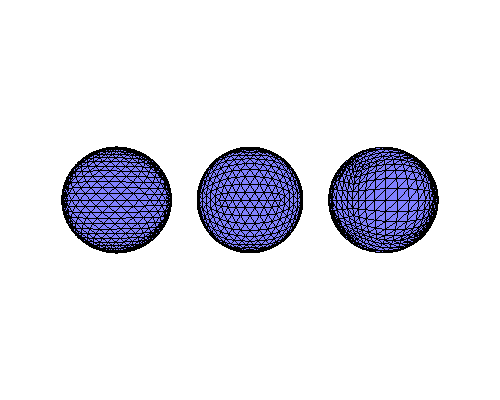

In [3]:
from IPython.display import display
from vispy import scene
from vispy.visuals.transforms import STTransform

canvas = scene.SceneCanvas(keys='interactive', bgcolor='white',
                           size=(500, 400), show=True, resizable=True)

view = canvas.central_widget.add_view()
view.camera = 'arcball'

sphere1 = scene.visuals.Sphere(radius=1, method='latitude', parent=view.scene,
                               edge_color='black')

sphere2 = scene.visuals.Sphere(radius=1, method='ico', parent=view.scene,
                               edge_color='black')

sphere3 = scene.visuals.Sphere(radius=1, rows=10, cols=10, depth=10,
                               method='cube', parent=view.scene,
                               edge_color='black')

sphere1.transform = STTransform(translate=[-2.5, 0, 0])
sphere3.transform = STTransform(translate=[2.5, 0, 0])

view.camera.set_range(x=[-3, 3])
canvas